# comparison of ya and oa psd

This notebook imports 20-second resting state eyes closed EEG and computes the average PSD for both oa and ya subjects, in order to compare how PSDs differ.

In [3]:
%matplotlib inline
import os
import glob
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import signal
from scipy import io
from sklearn import metrics, cross_validation
from sklearn import linear_model

In [4]:
subjoa = {} # Dictionary that holds subject data
subjya = {}
srate = 512

matfiles_oa = []
matfiles_ya = []
for root, dirs, files in os.walk('../data/examine-slope-fit/no-filt/oa-mat/'):
    matfiles_oa += glob.glob(os.path.join(root, '*.mat'))
for root, dirs, files in os.walk('../data/examine-slope-fit/no-filt/ya-mat/'):
    matfiles_ya += glob.glob(os.path.join(root, '*.mat'))
    
# Remove superagers
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127107.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127113.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127115.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127118.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127119.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127120.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127122.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127135.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127137.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127138.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127139.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127144.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127145.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127147.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127148.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127155.mat')
matfiles_oa.remove('../data/examine-slope-fit/no-filt/oa-mat/120127157.mat')

for i in range(len(matfiles_oa)):
    datafile = sp.io.loadmat(matfiles_oa[i])
    subjoa[i] = {}
    subjoa[i]['name'] = str(np.squeeze(datafile['name']))
    subjoa[i]['data'] = np.squeeze(datafile['data'])    
for i in range(len(matfiles_ya)):
    datafile = sp.io.loadmat(matfiles_ya[i])
    subjya[i] = {}
    subjya[i]['name'] = str(np.squeeze(datafile['name']))
    subjya[i]['data'] = np.squeeze(datafile['data'])

In [5]:
def compute_slope(f, psd, lofreq, hifreq):
    """ 
    Robustly fits line to PSD. Returns slope and fit line. 
    Note that we fit to the PSD in semi-log space.
    """
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0][0] * (10**2), fit_line

In [6]:
# Younger adults
for i in subjya:
    for ch in range(len(subjya[i]['data'])):

        subjya[i][ch] = {}
        
        f, psd = sp.signal.welch(subjya[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjya[i][ch]['f'] = f
        subjya[i][ch]['psd'] = psd
        
        # Remove alpha peak from the power spectrum:        
        subjya[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjya[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjya[i][ch]['psd_sans_alpha'] = subjya[i][ch]['psd_sans_alpha'].reshape((len(subjya[i][ch]['psd_sans_alpha']), 1))
        subjya[i][ch]['f_sans_alpha']   = subjya[i][ch]['f_sans_alpha'].reshape((len(subjya[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line
        subjya[i][ch]['slope'], subjya[i][ch]['fit_line'] = compute_slope(subjya[i][ch]['f_sans_alpha'], 
                                                                          subjya[i][ch]['psd_sans_alpha'],
                                                                          100, 250)
    # Compute average slope for this subject
    slopes = []
    for ch in range(len(subjya[i]['data'])):
        slopes.append(subjya[i][ch]['slope'])
    subjya[i]['avg_psd_slope'] = np.mean(slopes)
    
    # Compute average psd for this subject
    psds = []
    for ch in range(len(subjoa[i]['data'])):
        psds.append(subjya[i][ch]['psd'])
    subjya[i]['avg_psd'] = np.mean(psds, axis=0)
    
# Older adults
for i in subjoa:
    for ch in range(len(subjoa[i]['data'])):

        subjoa[i][ch] = {}
        
        f, psd = sp.signal.welch(subjoa[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjoa[i][ch]['f'] = f
        subjoa[i][ch]['psd'] = psd
        
        # Remove alpha peak from the power spectrum:        
        subjoa[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjoa[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjoa[i][ch]['psd_sans_alpha'] = subjoa[i][ch]['psd_sans_alpha'].reshape((len(subjoa[i][ch]['psd_sans_alpha']), 1))
        subjoa[i][ch]['f_sans_alpha']   = subjoa[i][ch]['f_sans_alpha'].reshape((len(subjoa[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line
        subjoa[i][ch]['slope'], subjoa[i][ch]['fit_line'] = compute_slope(subjoa[i][ch]['f_sans_alpha'], 
                                                                          subjoa[i][ch]['psd_sans_alpha'],
                                                                          100, 250)
    # Compute average slope for this subject
    slopes = []
    for ch in range(len(subjoa[i]['data'])):
        slopes.append(subjoa[i][ch]['slope'])
    subjoa[i]['avg_psd_slope'] = np.mean(slopes)
    
    # Compute average psd for this subject
    psds = []
    for ch in range(len(subjoa[i]['data'])):
        psds.append(subjoa[i][ch]['psd'])
    subjoa[i]['avg_psd'] = np.mean(psds, axis=0)

In [7]:
ya_avg_psd = np.mean([subjya[i]['avg_psd'] for i in range(len(subjya))], axis=0)
oa_avg_psd = np.mean([subjoa[i]['avg_psd'] for i in range(len(subjoa))], axis=0)

(0, 50)

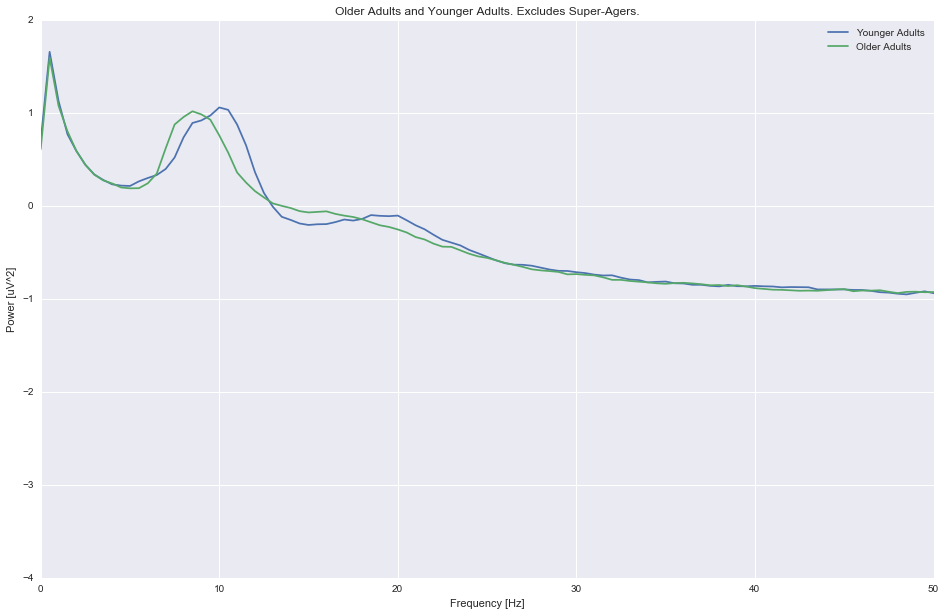

In [9]:
plt.figure(figsize=(16, 10)); #plt.xlim([0, 100])
plt.plot(subjoa[0][0]['f'], np.log10(ya_avg_psd), label='Younger Adults')
plt.plot(subjoa[0][0]['f'], np.log10(oa_avg_psd), label='Older Adults')
plt.plot
plt.xlabel('Frequency [Hz]'); plt.ylabel('Power [uV^2]'); plt.legend()
plt.title('Older Adults and Younger Adults. Excludes Super-Agers.'); plt.xlim([0, 50])

In [10]:
subjoa = {} # Dictionary that holds subject data
subjya = {}
srate = 512

matfiles_oa = []
matfiles_ya = []
for root, dirs, files in os.walk('../data/examine-slope-fit/no-filt/oa-mat/'):
    matfiles_oa += glob.glob(os.path.join(root, '*.mat'))
for root, dirs, files in os.walk('../data/examine-slope-fit/no-filt/ya-mat/'):
    matfiles_ya += glob.glob(os.path.join(root, '*.mat'))

for i in range(len(matfiles_oa)):
    datafile = sp.io.loadmat(matfiles_oa[i])
    subjoa[i] = {}
    subjoa[i]['name'] = str(np.squeeze(datafile['name']))
    subjoa[i]['data'] = np.squeeze(datafile['data'])    
for i in range(len(matfiles_ya)):
    datafile = sp.io.loadmat(matfiles_ya[i])
    subjya[i] = {}
    subjya[i]['name'] = str(np.squeeze(datafile['name']))
    subjya[i]['data'] = np.squeeze(datafile['data'])

In [11]:
# Younger adults
for i in subjya:
    for ch in range(len(subjya[i]['data'])):

        subjya[i][ch] = {}
        
        f, psd = sp.signal.welch(subjya[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjya[i][ch]['f'] = f
        subjya[i][ch]['psd'] = psd
        
        # Remove alpha peak from the power spectrum:        
        subjya[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjya[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjya[i][ch]['psd_sans_alpha'] = subjya[i][ch]['psd_sans_alpha'].reshape((len(subjya[i][ch]['psd_sans_alpha']), 1))
        subjya[i][ch]['f_sans_alpha']   = subjya[i][ch]['f_sans_alpha'].reshape((len(subjya[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line
        subjya[i][ch]['slope'], subjya[i][ch]['fit_line'] = compute_slope(subjya[i][ch]['f_sans_alpha'], 
                                                                          subjya[i][ch]['psd_sans_alpha'],
                                                                          100, 250)
    # Compute average slope for this subject
    slopes = []
    for ch in range(len(subjya[i]['data'])):
        slopes.append(subjya[i][ch]['slope'])
    subjya[i]['avg_psd_slope'] = np.mean(slopes)
    
    # Compute average psd for this subject
    psds = []
    for ch in range(len(subjoa[i]['data'])):
        psds.append(subjya[i][ch]['psd'])
    subjya[i]['avg_psd'] = np.mean(psds, axis=0)
    
# Older adults
for i in subjoa:
    for ch in range(len(subjoa[i]['data'])):

        subjoa[i][ch] = {}
        
        f, psd = sp.signal.welch(subjoa[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjoa[i][ch]['f'] = f
        subjoa[i][ch]['psd'] = psd
        
        # Remove alpha peak from the power spectrum:        
        subjoa[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjoa[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjoa[i][ch]['psd_sans_alpha'] = subjoa[i][ch]['psd_sans_alpha'].reshape((len(subjoa[i][ch]['psd_sans_alpha']), 1))
        subjoa[i][ch]['f_sans_alpha']   = subjoa[i][ch]['f_sans_alpha'].reshape((len(subjoa[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line
        subjoa[i][ch]['slope'], subjoa[i][ch]['fit_line'] = compute_slope(subjoa[i][ch]['f_sans_alpha'], 
                                                                          subjoa[i][ch]['psd_sans_alpha'],
                                                                          100, 250)
    # Compute average slope for this subject
    slopes = []
    for ch in range(len(subjoa[i]['data'])):
        slopes.append(subjoa[i][ch]['slope'])
    subjoa[i]['avg_psd_slope'] = np.mean(slopes)
    
    # Compute average psd for this subject
    psds = []
    for ch in range(len(subjoa[i]['data'])):
        psds.append(subjoa[i][ch]['psd'])
    subjoa[i]['avg_psd'] = np.mean(psds, axis=0)

In [12]:
ya_avg_psd = np.mean([subjya[i]['avg_psd'] for i in range(len(subjya))], axis=0)
oa_avg_psd = np.mean([subjoa[i]['avg_psd'] for i in range(len(subjoa))], axis=0)

(0, 50)

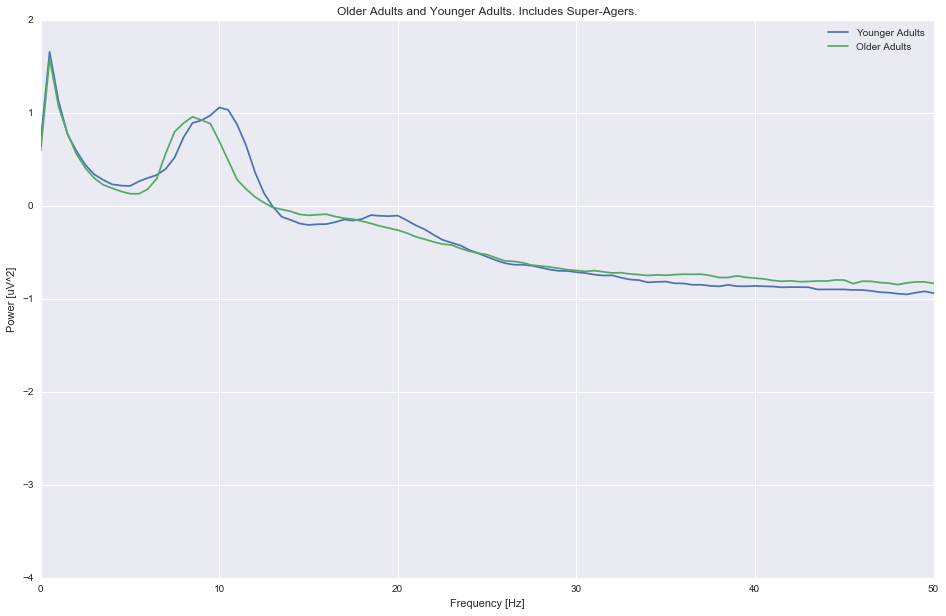

In [13]:
plt.figure(figsize=(16, 10)); #plt.xlim([0, 45])
plt.plot(subjoa[0][0]['f'], np.log10(ya_avg_psd), label='Younger Adults')
plt.plot(subjya[0][0]['f'], np.log10(oa_avg_psd), label='Older Adults')
plt.xlabel('Frequency [Hz]'); plt.ylabel('Power [uV^2]'); plt.legend()
plt.title('Older Adults and Younger Adults. Includes Super-Agers.'); plt.xlim([0, 50])

In [74]:
sa_names = ["120127107","120127113","120127115","120127118","120127119","120127120","120127122","120127135","120127137","120127138","120127139","120127144","120127145","120127147","120127148","120127155","120127157"]
sa_avg_psd = np.mean([subjoa[i]['avg_psd'] for i in range(len(subjoa)) if subjoa[i]['name'] in sa_names], axis=0)

In [1]:
plt.figure(figsize=(16, 10));
plt.plot(subjoa[0][0]['f'], np.log10(ya_avg_psd), label='Younger Adults')
plt.plot(subjya[0][0]['f'], np.log10(sa_avg_psd), label='Super Agers')
plt.plot(subjya[0][0]['f'], np.log10(oa_avg_psd), label='Older Adults')
plt.xlabel('Frequency [Hz]'); plt.ylabel('Power [uV^2]'); plt.legend()
plt.title('Younger Adults, Older Adults, Super-Agers'); plt.xlim([0, 80])

NameError: name 'plt' is not defined